In [135]:
import psycopg2
# to install from commandline: conda install -c anaconda psycopg2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

#need to be connected to vpn
import config 
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

In [17]:
# Models/algorithms/classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation of models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score


https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iv/concepts/score/oasis.sql - oasis score easier to run because does it in the first day and also predicts mortality and also keeps the raw result - can try to modify sofa to do this as well 

https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01517-7 - paper applying oasis features to MIMIC-III with machine learning models 


In [101]:
oasis = pd.read_csv("first_day_oasis_score2-23-22.csv") 
#https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iv/concepts/score/oasis.sql
#ran on bigquery using derived tables, exported first 10000 cases
oasis.head()

,subject_id,hadm_id,stay_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
0,18329324,24947486,38717050,58,0.772134,52,3,1,5,7.0,10.0,191.0,6.0,54.0,2.0,4.0,10.0,37.39,2.0,760.0,5.0,1,9,0,6
1,17957832,21164559,33682689,57,0.748927,67,6,0,5,13.0,4.0,128.0,6.0,146.0,3.0,33.0,6.0,39.40,2.0,238.0,10.0,1,9,0,6
2,16613161,23377835,36051938,59,0.793786,52,3,0,5,3.0,10.0,120.0,3.0,35.0,3.0,42.0,6.0,34.70,4.0,30.0,10.0,1,9,0,6
3,14360149,25834248,37906915,58,0.772134,68,6,4,5,15.0,0.0,140.0,6.0,50.0,3.0,1.0,10.0,33.20,3.0,5.0,10.0,1,9,0,6
4,16731711,23567649,38774055,67,0.914347,78,9,18964,2,7.0,10.0,137.0,6.0,14.0,4.0,46.0,9.0,36.00,2.0,320.0,10.0,1,9,0,6


In [102]:
oasis.shape

(10000, 25)

In [136]:
sql = query_schema + """
select *
from mimiciv.admissions
limit 5
"""
df = pd.read_sql_query(sql,conn) 
df


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,14679932,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,None,ELECTIVE,None,HOME,Other,ENGLISH,SINGLE,UNKNOWN,None,None,0
1,15585972,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,None,ELECTIVE,None,HOME,Other,ENGLISH,None,WHITE,None,None,0
2,11989120,21965160,2147-01-14 09:00:00,2147-01-17 14:25:00,None,ELECTIVE,None,HOME,Other,ENGLISH,None,UNKNOWN,None,None,0
3,17817079,24709883,2165-12-27 17:33:00,2165-12-31 21:18:00,None,ELECTIVE,None,HOME,Other,ENGLISH,None,OTHER,None,None,0
4,15078341,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,None,ELECTIVE,None,HOME,Other,ENGLISH,None,BLACK/AFRICAN AMERICAN,None,None,0


In [138]:
sql = query_schema + """
select hadm_id, ethnicity, admittime, dischtime, hospital_expire_flag, admission_location, discharge_location 
from mimiciv.admissions
limit 5
"""
admit = pd.read_sql_query(sql,conn) 
admit


,hadm_id,ethnicity,admittime,dischtime,hospital_expire_flag,admission_location,discharge_location
0,21038362,UNKNOWN,2139-09-26 14:16:00,2139-09-28 11:30:00,0,None,HOME
1,24941086,WHITE,2123-10-07 23:56:00,2123-10-12 11:22:00,0,None,HOME
2,21965160,UNKNOWN,2147-01-14 09:00:00,2147-01-17 14:25:00,0,None,HOME
3,24709883,OTHER,2165-12-27 17:33:00,2165-12-31 21:18:00,0,None,HOME
4,23272159,BLACK/AFRICAN AMERICAN,2122-08-28 08:48:00,2122-08-30 12:32:00,0,None,HOME


In [148]:
sql = query_schema + """
select hadm_id, ethnicity, admittime, dischtime, hospital_expire_flag, admission_location, discharge_location 
from mimiciv.admissions
"""
admit = pd.read_sql_query(sql,conn) 
admit


,hadm_id,ethnicity,admittime,dischtime,hospital_expire_flag,admission_location,discharge_location
0,21038362,UNKNOWN,2139-09-26 14:16:00,2139-09-28 11:30:00,0,None,HOME
1,24941086,WHITE,2123-10-07 23:56:00,2123-10-12 11:22:00,0,None,HOME
2,21965160,UNKNOWN,2147-01-14 09:00:00,2147-01-17 14:25:00,0,None,HOME
3,24709883,OTHER,2165-12-27 17:33:00,2165-12-31 21:18:00,0,None,HOME
4,23272159,BLACK/AFRICAN AMERICAN,2122-08-28 08:48:00,2122-08-30 12:32:00,0,None,HOME
...,...,...,...,...,...,...,...
523735,20786062,WHITE,2180-09-17 00:00:00,2180-09-18 13:37:00,0,PHYSICIAN REFERRAL,HOME
523736,20943099,HISPANIC/LATINO,2147-08-01 17:41:00,2147-08-02 17:30:00,0,TRANSFER FROM HOSPITAL,HOME
523737,23176714,WHITE,2189-03-01 00:58:00,2189-03-02 15:22:00,0,PHYSICIAN REFERRAL,HOME
523738,22347500,WHITE,2138-05-31 00:00:00,2138-06-04 16:50:00,0,PHYSICIAN REFERRAL,HOME HEALTH CARE


In [149]:
admit.to_csv("dispo_ethnicity2-24-22.csv")

In [151]:
admit.groupby('ethnicity').hospital_expire_flag.value_counts()

ethnicity                      hospital_expire_flag
AMERICAN INDIAN/ALASKA NATIVE  0                         1518
                               1                           17
ASIAN                          0                        24163
                               1                          343
BLACK/AFRICAN AMERICAN         0                        79392
                               1                          901
HISPANIC/LATINO                0                        29561
                               1                          262
OTHER                          0                        26431
                               1                          382
UNABLE TO OBTAIN               0                         3591
                               1                          149
UNKNOWN                        0                        18080
                               1                         1320
WHITE                          0                       331654
                  

In [152]:
ethnicity_mortality = admit.groupby('ethnicity').hospital_expire_flag.value_counts()

In [ ]:
#calculate % for each ethnicity's mortality? I'm sure there's a python way to do this 

AMERICAN INDIAN/ALASKA NATIVE  0                         1518
                               1                           17
    17/1518 = 0.0112
    
ASIAN                          0                        24163
                               1                          343
    
    0.0142
    
BLACK/AFRICAN AMERICAN         0                        79392
                               1                          901
    0.0113
    
    
HISPANIC/LATINO                0                        29561
                               1                          262
    0.00886
    
OTHER                          0                        26431
                               1                          382
UNABLE TO OBTAIN               0                         3591
                               1                          149
UNKNOWN                        0                        18080
                               1                         1320
WHITE                          0                       331654
                               1                         5976
    
    0.0180

In [155]:
admit.groupby('discharge_location').hospital_expire_flag.value_counts() 
#umm, why isn't this perfect? shouldn't died be all 1s? ehh, we will use hospital_expire_flag for now

discharge_location            hospital_expire_flag
ACUTE HOSPITAL                0                         3496
                              1                            3
AGAINST ADVICE                0                         2718
ASSISTED LIVING               0                          584
CHRONIC/LONG TERM ACUTE CARE  0                         7587
                              1                            4
DIED                          1                         9058
                              0                          180
HEALTHCARE FACILITY           0                          168
HOME                          0                       222089
                              1                           84
HOME HEALTH CARE              0                        86019
                              1                            7
HOSPICE                       0                         3665
                              1                           14
OTHER FACILITY                0   

In [157]:
death = admit[['hadm_id','ethnicity','hospital_expire_flag']]
death.head()

,hadm_id,ethnicity,hospital_expire_flag
0,21038362,UNKNOWN,0
1,24941086,WHITE,0
2,21965160,UNKNOWN,0
3,24709883,OTHER,0
4,23272159,BLACK/AFRICAN AMERICAN,0


In [ ]:
dispo = pd.read_csv("discharge_disposition_clean2-20-22.csv")
dispo.head()

,Unnamed: 0,hadm_id,admittime,dischtime,deathtime,hospital_expire_flag,admission_location,discharge_location
0,0,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaN,0,NaN,Home
1,1,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaN,0,NaN,Home
2,2,21965160,2147-01-14 09:00:00,2147-01-17 14:25:00,NaN,0,NaN,Home
3,3,24709883,2165-12-27 17:33:00,2165-12-31 21:18:00,NaN,0,NaN,Home
4,4,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaN,0,NaN,Home


In [9]:
death = dispo[['hadm_id','hospital_expire_flag']]
death.head()

,hadm_id,hospital_expire_flag
0,21038362,0
1,24941086,0
2,21965160,0
3,24709883,0
4,23272159,0


In [10]:
death.hospital_expire_flag.value_counts()

0    514390
1      9350
Name: hospital_expire_flag, dtype: int64

In [8]:
#link hadm_id and stay_id - is this in icustays?

sql = query_schema + """
select hadm_id, stay_id
from mimiciv.icustays
"""
admstay = pd.read_sql_query(sql,conn) 
admstay


,hadm_id,stay_id
0,24528534,31793211
1,28960964,31983544
2,27385897,33183475
3,23483021,34131444
4,20817525,34547665
...,...,...
76535,27299174,39990887
76536,28911582,39991872
76537,22562812,39992247
76538,24221219,39993265


In [158]:
death_id = pd.merge(admstay, death)
death_id.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag
0,24528534,31793211,UNABLE TO OBTAIN,0
1,28960964,31983544,WHITE,0
2,27385897,33183475,WHITE,1
3,23483021,34131444,WHITE,0
4,20817525,34547665,OTHER,0


In [159]:
death_id_oasis = pd.merge(death_id, oasis)
death_id_oasis.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag,subject_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
0,24528534,31793211,UNABLE TO OBTAIN,0,17867402,33,0.122701,25,3,62,3,13.0,4.0,62.5,0.0,93.5,0.0,11.0,1.0,36.11,2.0,1105.0,5.0,1,9,0,6
1,26340268,32550034,WHITE,0,16841280,31,0.097783,60,6,97,3,14.0,3.0,100.0,1.0,59.0,2.0,8.0,1.0,35.78,4.0,820.0,5.0,0,0,0,6
2,22177535,35370343,BLACK/AFRICAN AMERICAN,0,10390732,20,0.025967,52,3,20003,2,14.0,3.0,113.0,3.0,94.5,0.0,28.0,1.0,37.50,2.0,2845.0,0.0,0,0,0,6
3,22177535,33180725,BLACK/AFRICAN AMERICAN,0,10390732,31,0.097783,52,3,1,5,8.0,4.0,76.0,0.0,96.0,0.0,5.0,10.0,36.89,2.0,1738.0,1.0,0,0,0,6
4,21776160,30655167,UNKNOWN,0,17530304,30,0.087098,91,7,103,3,15.0,0.0,125.0,3.0,46.0,3.0,28.0,1.0,36.39,2.0,730.0,5.0,0,0,0,6


In [160]:
death_id_oasis.hospital_expire_flag.value_counts()

0    8296
1    1704
Name: hospital_expire_flag, dtype: int64

In [161]:
death_id_oasis.shape

(10000, 27)

How does the OASIS score compare with actual hospital mortality? let's make a confusion matrix for everyone - 



In [171]:
#round oasis probability to 0/1

death_id_oasis['rounded_oasis'] = death_id_oasis['oasis_prob'].round(0)

In [109]:
death_id_oasis['rounded_oasis']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9995    0.0
9996    0.0
9997    0.0
9998    0.0
9999    0.0
Name: rounded_oasis, Length: 10000, dtype: float64

In [110]:
death_id_oasis.rounded_oasis.value_counts() #underestimating death it appears 

0.0    9337
1.0     663
Name: rounded_oasis, dtype: int64

In [115]:
death_id_oasis[['oasis_prob','rounded_oasis', 'hospital_expire_flag']].sample(100)

,oasis_prob,rounded_oasis,hospital_expire_flag
9086,0.077479,0.0,0
2527,0.068843,0.0,0
9441,0.042509,0.0,0
6302,0.009522,0.0,0
7387,0.486353,0.0,1
...,...,...,...
2330,0.423212,0.0,1
1123,0.279468,0.0,0
1323,0.054187,0.0,1
6359,0.152892,0.0,0


In [116]:
#Generate the confusion matrix
print(confusion_matrix(death_id_oasis['hospital_expire_flag'], death_id_oasis['rounded_oasis']))


[[8011  285]
 [1326  378]]


In [128]:
death = death_id_oasis['hospital_expire_flag']
predicted = death_id_oasis['rounded_oasis']

In [121]:
# from https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    
    return(TP, FP, TN, FN)

In [122]:
perf_measure(death, predicted)

(378, 285, 8011, 1326)

In [125]:
def perf_measure2(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    sensitivity  = TP / (TP+FN)
    specificity  = TN / (TN+FP)
    pos_pred_val = TP/ (TP+FP)
    neg_pred_val = TN/ (TN+FN)

    return sensitivity, specificity, pos_pred_val, neg_pred_val

In [126]:
perf_measure2(death, predicted) #not very sensitive but very specific lol 

(0.22183098591549297,
 0.9656460945033751,
 0.5701357466063348,
 0.857984363285852)

In [147]:
print(confusion_matrix(death, predicted))


[[8011  285]
 [1326  378]]


In [142]:
tpr

array([0.        , 0.22183099, 1.        ])

In [144]:
o_auc = roc_auc_score(death, predicted)
print(o_auc)

TypeError: '<' not supported between instances of 'str' and 'int'

In [145]:
o_fpr, o_tpr, _ = roc_curve(death, predicted)

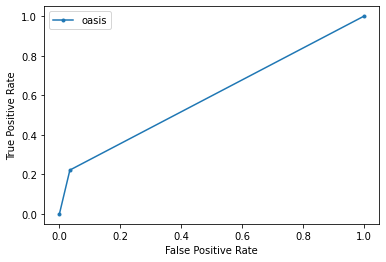

In [146]:
plt.plot(o_fpr, o_tpr, marker='.', label='oasis')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
#why is it so jagged? 

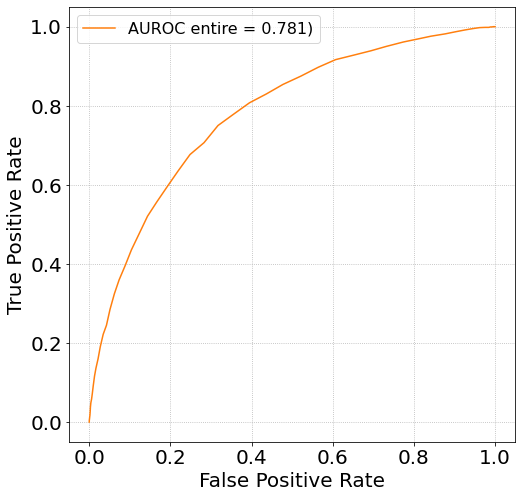

In [255]:
# try again to make sure didn't write something wrong? 
fpr, tpr, _ = roc_curve(death_id_oasis['hospital_expire_flag'], death_id_oasis['oasis_prob'])
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="AUROC entire = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

Logistic: f1=0.500 auc=0.440


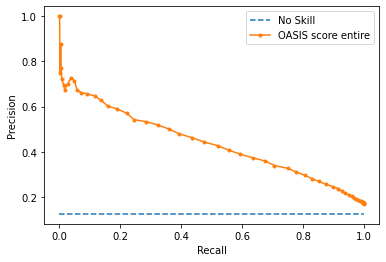

In [256]:
o_precision, o_recall, _ = precision_recall_curve(death_id_oasis['hospital_expire_flag'], death_id_oasis['oasis_prob'])
o_f1, o_auc = f1_score(Y_test, yhat), auc(o_recall, o_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (o_f1, o_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(o_recall, o_precision, marker='.', label='OASIS score entire')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [162]:
death_id_oasis.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag,subject_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,rounded_oasis
0,24528534,31793211,UNABLE TO OBTAIN,0,17867402,33,0.122701,25,3,62,3,13.0,4.0,62.5,0.0,93.5,0.0,11.0,1.0,36.11,2.0,1105.0,5.0,1,9,0,6,0.0
1,26340268,32550034,WHITE,0,16841280,31,0.097783,60,6,97,3,14.0,3.0,100.0,1.0,59.0,2.0,8.0,1.0,35.78,4.0,820.0,5.0,0,0,0,6,0.0
2,22177535,35370343,BLACK/AFRICAN AMERICAN,0,10390732,20,0.025967,52,3,20003,2,14.0,3.0,113.0,3.0,94.5,0.0,28.0,1.0,37.50,2.0,2845.0,0.0,0,0,0,6,0.0
3,22177535,33180725,BLACK/AFRICAN AMERICAN,0,10390732,31,0.097783,52,3,1,5,8.0,4.0,76.0,0.0,96.0,0.0,5.0,10.0,36.89,2.0,1738.0,1.0,0,0,0,6,0.0
4,21776160,30655167,UNKNOWN,0,17530304,30,0.087098,91,7,103,3,15.0,0.0,125.0,3.0,46.0,3.0,28.0,1.0,36.39,2.0,730.0,5.0,0,0,0,6,0.0


In [244]:
white = death_id_oasis[death_id_oasis['ethnicity']=='WHITE']

In [168]:
white.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag,subject_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,rounded_oasis
1,26340268,32550034,WHITE,0,16841280,31,0.097783,60,6,97,3,14.0,3.0,100.0,1.0,59.0,2.0,8.0,1.0,35.78,4.0,820.0,5.0,0,0,0,6,0.0
6,25778760,30001555,WHITE,0,10656173,24,0.042509,34,3,25095,2,13.0,4.0,71.5,0.0,76.5,0.0,33.0,6.0,36.89,2.0,2335.0,1.0,0,0,0,6,0.0
7,25778760,37985659,WHITE,0,10656173,36,0.170145,34,3,100,3,11.0,4.0,120.0,3.0,74.0,0.0,29.0,1.0,39.06,2.0,705.0,5.0,1,9,0,6,0.0
11,28935387,30014139,WHITE,0,11239965,35,0.152892,42,3,51,3,12.0,4.0,109.0,3.0,95.5,0.0,31.0,6.0,37.78,2.0,6930.0,8.0,0,0,0,6,0.0
14,23657972,30029202,WHITE,0,17051420,26,0.054187,52,3,43,3,15.0,0.0,141.0,6.0,98.5,0.0,38.0,6.0,36.39,2.0,4875.0,0.0,0,0,0,6,0.0


In [175]:
print(confusion_matrix(white['hospital_expire_flag'], white['rounded_oasis']))


[[3356  113]
 [ 373   96]]


In [245]:
white_death = white['hospital_expire_flag']
white_pred = white['oasis_prob']

In [248]:
print(metrics.accuracy_score(white_death, white['rounded_oasis']))

0.8765871000507872


In [190]:
confusion = confusion_matrix(white['hospital_expire_flag'], white['rounded_oasis'])

In [192]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print (TP, TN, FP, FN)

96 3356 113 373


In [193]:
sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)
pos_pred_val = TP/ (TP+FP)
neg_pred_val = TN/ (TN+FN)
print(sensitivity, specificity, pos_pred_val, neg_pred_val)

In [194]:
print(sensitivity, specificity, pos_pred_val, neg_pred_val)

0.2046908315565032 0.9674257711155952 0.45933014354066987 0.8999731831590239


In [191]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

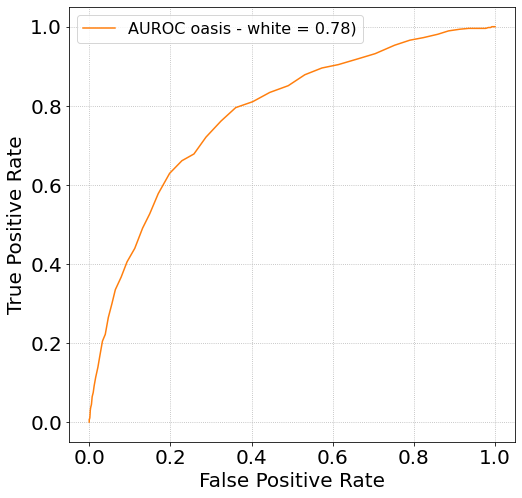

In [257]:
# try again to make sure didn't write something wrong? 
fpr, tpr, _ = roc_curve(white_death, white_pred)
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="AUROC oasis - white = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

Logistic: f1=0.500 auc=0.341


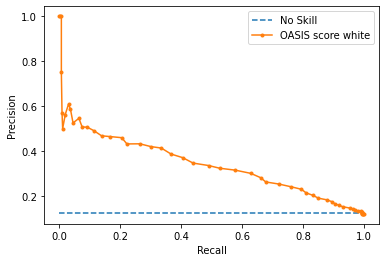

In [260]:
o_precision, o_recall, _ = precision_recall_curve(white['hospital_expire_flag'], white['oasis_prob'])
o_f1, o_auc = f1_score(Y_test, yhat), auc(o_recall, o_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (o_f1, o_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(o_recall, o_precision, marker='.', label='OASIS score white')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [250]:
black = death_id_oasis[death_id_oasis['ethnicity']=='BLACK/AFRICAN AMERICAN']

In [254]:
confusion = confusion_matrix(black['hospital_expire_flag'], black['rounded_oasis'])

In [203]:
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print (TP, TN, FP, FN)


[[595  19]
 [ 46  19]]
19 595 19 46


In [204]:
sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)
pos_pred_val = TP/ (TP+FP)
neg_pred_val = TN/ (TN+FN)
print(sensitivity, specificity, pos_pred_val, neg_pred_val)

0.2923076923076923 0.9690553745928339 0.5 0.9282371294851794


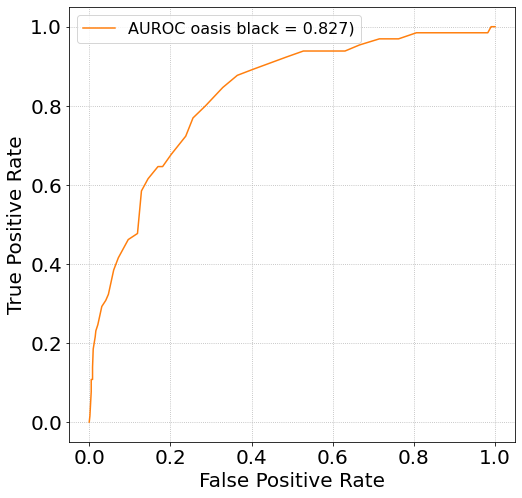

In [258]:
fpr, tpr, _ = roc_curve(black['hospital_expire_flag'], black['oasis_prob'])
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="AUROC oasis black = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

Logistic: f1=0.500 auc=0.377


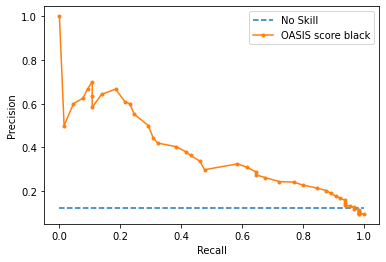

In [261]:
o_precision, o_recall, _ = precision_recall_curve(black['hospital_expire_flag'], black['oasis_prob'])
o_f1, o_auc = f1_score(Y_test, yhat), auc(o_recall, o_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (o_f1, o_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(o_recall, o_precision, marker='.', label='OASIS score black')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

now, let's run a very simple xgboost model to see if first day's labs can predict mortality
based on https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/ tutorial


In [206]:
death_id_oasis.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag,subject_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,rounded_oasis
0,24528534,31793211,UNABLE TO OBTAIN,0,17867402,33,0.122701,25,3,62,3,13.0,4.0,62.5,0.0,93.5,0.0,11.0,1.0,36.11,2.0,1105.0,5.0,1,9,0,6,0.0
1,26340268,32550034,WHITE,0,16841280,31,0.097783,60,6,97,3,14.0,3.0,100.0,1.0,59.0,2.0,8.0,1.0,35.78,4.0,820.0,5.0,0,0,0,6,0.0
2,22177535,35370343,BLACK/AFRICAN AMERICAN,0,10390732,20,0.025967,52,3,20003,2,14.0,3.0,113.0,3.0,94.5,0.0,28.0,1.0,37.50,2.0,2845.0,0.0,0,0,0,6,0.0
3,22177535,33180725,BLACK/AFRICAN AMERICAN,0,10390732,31,0.097783,52,3,1,5,8.0,4.0,76.0,0.0,96.0,0.0,5.0,10.0,36.89,2.0,1738.0,1.0,0,0,0,6,0.0
4,21776160,30655167,UNKNOWN,0,17530304,30,0.087098,91,7,103,3,15.0,0.0,125.0,3.0,46.0,3.0,28.0,1.0,36.39,2.0,730.0,5.0,0,0,0,6,0.0


In [209]:
death_id_oasis['hospital_expire_flag'] #outcome of interest, Y 


0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    0
9997    0
9998    0
9999    0
Name: hospital_expire_flag, Length: 10000, dtype: int64

In [ ]:
Y=death_id_oasis['hospital_expire_flag']

In [210]:
Y=death_id_oasis['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]

X = death_id_oasis[columns_to_keep]

In [212]:
X.head()

,age,preiculos,gcs,heartrate,meanbp,resprate,temp,urineoutput,mechvent,electivesurgery
0,25,62,13.0,62.5,93.5,11.0,36.11,1105.0,1,0
1,60,97,14.0,100.0,59.0,8.0,35.78,820.0,0,0
2,52,20003,14.0,113.0,94.5,28.0,37.50,2845.0,0,0
3,52,1,8.0,76.0,96.0,5.0,36.89,1738.0,0,0
4,91,103,15.0,125.0,46.0,28.0,36.39,730.0,0,0


In [214]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [215]:
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:04:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [216]:
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]

In [217]:
# evaluate predictions
accuracy = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.05%


In [218]:
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

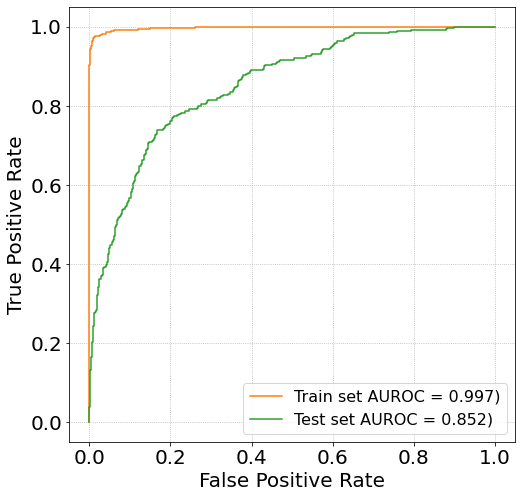

In [219]:
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [220]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(Y_test, Y_test_pred)

print(cf_matrix)


[[1573   78]
 [ 201  148]]


In [221]:
xg_probs = model.predict_proba(X_test)
xg_probs = xg_probs[:, 1]
yhat = model.predict(X_test)
xg_precision, xg_recall, _ = precision_recall_curve(Y_test, xg_probs)
xg_f1, xg_auc = f1_score(Y_test, yhat), auc(xg_recall, xg_precision)

Logistic: f1=0.515 auc=0.613


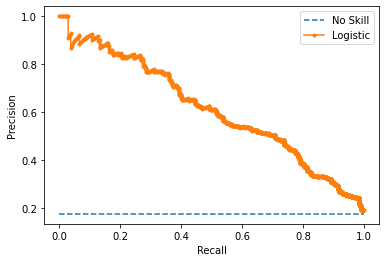

In [222]:
xg_probs = model.predict_proba(X_test)
xg_probs = xg_probs[:, 1]
yhat = model.predict(X_test)
xg_precision, xg_recall, _ = precision_recall_curve(Y_test, xg_probs)
xg_f1, xg_auc = f1_score(Y_test, yhat), auc(xg_recall, xg_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (xg_f1, xg_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(xg_recall, xg_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
xgboost on just white patients

In [226]:
white.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag,subject_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,rounded_oasis
1,26340268,32550034,WHITE,0,16841280,31,0.097783,60,6,97,3,14.0,3.0,100.0,1.0,59.0,2.0,8.0,1.0,35.78,4.0,820.0,5.0,0,0,0,6,0.0
6,25778760,30001555,WHITE,0,10656173,24,0.042509,34,3,25095,2,13.0,4.0,71.5,0.0,76.5,0.0,33.0,6.0,36.89,2.0,2335.0,1.0,0,0,0,6,0.0
7,25778760,37985659,WHITE,0,10656173,36,0.170145,34,3,100,3,11.0,4.0,120.0,3.0,74.0,0.0,29.0,1.0,39.06,2.0,705.0,5.0,1,9,0,6,0.0
11,28935387,30014139,WHITE,0,11239965,35,0.152892,42,3,51,3,12.0,4.0,109.0,3.0,95.5,0.0,31.0,6.0,37.78,2.0,6930.0,8.0,0,0,0,6,0.0
14,23657972,30029202,WHITE,0,17051420,26,0.054187,52,3,43,3,15.0,0.0,141.0,6.0,98.5,0.0,38.0,6.0,36.39,2.0,4875.0,0.0,0,0,0,6,0.0


In [227]:
Y=white['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = white[columns_to_keep]

In [228]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))




/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.23%


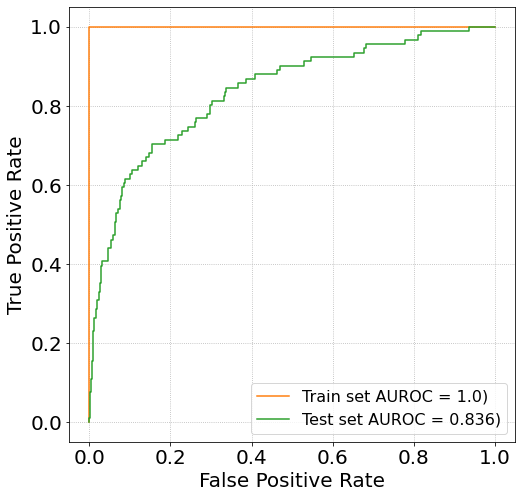

In [230]:
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [231]:

#Generate the confusion matrix
cf_matrix = confusion_matrix(Y_test, Y_test_pred)

print(cf_matrix)


[[683  14]
 [ 63  28]]


Logistic: f1=0.421 auc=0.492


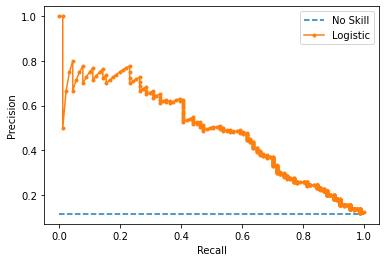

In [232]:
xg_probs = model.predict_proba(X_test)
xg_probs = xg_probs[:, 1]
yhat = model.predict(X_test)
xg_precision, xg_recall, _ = precision_recall_curve(Y_test, xg_probs)
xg_f1, xg_auc = f1_score(Y_test, yhat), auc(xg_recall, xg_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (xg_f1, xg_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(xg_recall, xg_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [234]:
black.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag,subject_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,rounded_oasis
2,22177535,35370343,BLACK/AFRICAN AMERICAN,0,10390732,20,0.025967,52,3,20003,2,14.0,3.0,113.0,3.0,94.5,0.0,28.0,1.0,37.50,2.0,2845.0,0.0,0,0,0,6,0.0
3,22177535,33180725,BLACK/AFRICAN AMERICAN,0,10390732,31,0.097783,52,3,1,5,8.0,4.0,76.0,0.0,96.0,0.0,5.0,10.0,36.89,2.0,1738.0,1.0,0,0,0,6,0.0
12,25117369,30020731,BLACK/AFRICAN AMERICAN,0,10836215,28,0.068843,64,6,151,3,15.0,0.0,76.0,0.0,91.5,0.0,26.0,1.0,37.06,2.0,300.0,10.0,0,0,0,6,0.0
16,22577891,30031116,BLACK/AFRICAN AMERICAN,0,18874154,33,0.122701,67,6,289,3,14.0,3.0,111.0,3.0,46.0,3.0,35.0,6.0,36.33,2.0,1545.0,1.0,0,0,0,6,0.0
18,26794760,30042091,BLACK/AFRICAN AMERICAN,0,13103745,21,0.029395,66,6,1379,0,15.0,0.0,100.0,1.0,89.5,0.0,27.0,1.0,37.00,2.0,1050.0,5.0,0,0,0,6,0.0


In [235]:
Y=black['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = black[columns_to_keep]

In [236]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[09:50:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 91.18%


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


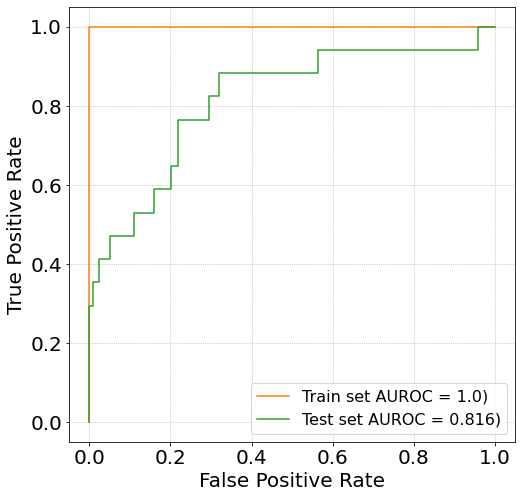

In [237]:
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

Logistic: f1=0.500 auc=0.566


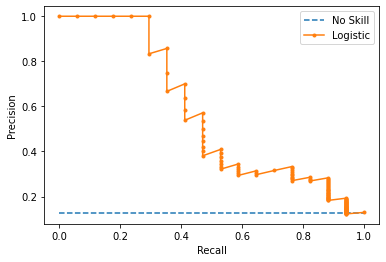

In [238]:
xg_probs = model.predict_proba(X_test)
xg_probs = xg_probs[:, 1]
yhat = model.predict(X_test)
xg_precision, xg_recall, _ = precision_recall_curve(Y_test, xg_probs)
xg_f1, xg_auc = f1_score(Y_test, yhat), auc(xg_recall, xg_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (xg_f1, xg_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(xg_recall, xg_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()